Data Collection 

To have the most detailed data available , I used an API to request daily Istanbul weather conditions.

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

API_KEY = "API_KEY"
CITY = "Istanbul"
DAYS_TO_FETCH = 366
START_DATE = "2019-01-01"
BASE_URL = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx"

current_date = datetime.strptime(START_DATE, "%Y-%m-%d")
all_weather_data = []

# Loop through DAYS_TO_FETCH and fetch daily average data
for _ in range(DAYS_TO_FETCH):
    date_str = current_date.strftime("%Y-%m-%d")
    print(f"Fetching data for {date_str}...")

    params = {
        "key": API_KEY,
        "q": CITY,
        "date": date_str,
        "format": "json",
        "tp": 24  # Fetch daily averages (one entry per day)
    }

    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        data = response.json()
        weather = data["data"]["weather"][0]
        
        # Extract daily averages and total precipitation
        avg_temp = weather["avgtempC"]  # Daily average temperature
        condition = weather["hourly"][0]["weatherDesc"][0]["value"]  # Most representative weather condition
        avg_humidity = weather["hourly"][0]["humidity"]  # Daily average humidity
        avg_wind_speed = weather["hourly"][0]["windspeedKmph"]  # Daily average wind speed
        total_precip = weather["hourly"][0]["precipMM"]  # Total precipitation in mm

        all_weather_data.append([date_str, avg_temp, condition, avg_humidity, avg_wind_speed, total_precip])
        print(f"Saved data for {date_str}.")
    else:
        print(f"Error fetching data for {date_str}: {response.status_code}")
        break  # Stop if API fails

    current_date += timedelta(days=1)

# Convert the collected data into a pandas DataFrame
df = pd.DataFrame(all_weather_data, columns=[
    "Date", "Avg Temperature (C)", "Condition", "Avg Humidity (%)", "Avg Wind Speed (km/h)", "Total Precipitation (mm)"
])

# Save the weather data to a CSV file
csv_filename = f"{CITY}_daily_weather_{START_DATE}.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8")


Lets Convert the monthly totals to seasonal Istanbul weather data

In [ ]:
import pandas as pd
         

# Load the CSV data
df = pd.read_csv("monthly_totals_2019-2024 .csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df.set_index('Date', inplace=True)

# Resample into 3-month (quarterly) periods starting from January
seasonal_means = df.resample('Q').mean()

# Rename the index to the starting month of the quarter (e.g., '2019-01')
seasonal_means.index = [i.to_timestamp(how='start').strftime('%Y-%m') for i in seasonal_means.index.to_period('Q')]

# Reset index and rename column and save to csv
seasonal_means.reset_index(inplace=True)
seasonal_means.rename(columns={'index': 'Season'}, inplace=True)
seasonal_means.to_csv("seasonal_averages.csv", index=False)

Now we have to convert the monthly tourists coming to Istanbul to Seasonal Data. Since I have the weather data of other countries as Quarterly , i will assume that every quarter is a season.

In [ ]:
import pandas as pd

#I used this code to create a seasonal tourist table from monthly tourist numbers

# Read the CSV file
df = pd.read_csv("milliyetlerine-gore-istanbul-a-gelen-yabanci-turist-sayisi.csv")

# Convert 'tarih' column to datetime
df['tarih'] = pd.to_datetime(df['tarih'])

# Create a new column every season
df['date'] = df['tarih'].dt.to_period('Q').dt.start_time

# Group each nationality
grouped = df.groupby(['uyruk', 'date'])['ziyaretci_sayisi'].sum().reset_index()

# Format the date as 'YYYY-MM'
grouped['date'] = grouped['date'].dt.strftime('%Y-%m')

# Reorder columns to make 'date' is first
grouped = grouped[['date', 'uyruk', 'ziyaretci_sayisi']]

# Save New CSV
grouped.to_csv("quarterly_visitors_by_country.csv", index=False)

Now Visitor numbers are in Seasonal however we can't merge it with other data yet because column names in 'uyruk' are in Turkish so we have to convert them to 3 letter ISO codes.

In [ ]:
#Main purpose of this code is to translate the turkish names in the quarterly_visitors_by_country.csv to 3 letter codes

import pandas as pd

# Load the tourist CSV
df_tourists = pd.read_csv("seasonal_visitors_by_country.csv")

# Add year column
df_tourists["Year"] = pd.to_datetime(df_tourists["date"]).dt.year

# Turkish to 3 letter code
turkish_to_iso3 = {
  "ABD":"USA",
  "Irak":"IRQ",
  "Bhutan":"BTN",
  "Çekya":"CZW",
  "Cabo Verde":"CPV",
  "Sao Tome":"STP",
  "Bahama Adaları":"BHS",
  "Kosova":"KOS",
  "Kongo Cumhuriyeti":"COG",
  "Saint Vincent":"VCT",
  "Saint Kitts":"KNA",
  "Mikronezya":"FSM",
  "Surinam":"SUR",
  "Yeşil Burun Adalar":"CPV",
  "Afganistan":"AFG",
  "Arnavutluk":"ALB",
  "Andorra":"AND",
  "Ermenistan":"ARM",
  "Avusturya":"AUT",
  "Azerbaycan":"AZE",
  "Belçika":"BEL",
  "Bulgaristan":"BGR",
  "Bosna-Hersek":"BIH",
  "Belarus":"BLR",
  "İsviçre":"CHE",
  "Kıbrıs":"CYP",
  "Çek Cumhuriyeti":"CZE",
  "Almanya":"DEU",
  "Danimarka":"DNK",
  "İspanya":"ESP",
  "Estonya":"EST",
  "Finlandiya":"FIN",
  "Fransa":"FRA",
  "Faroe Adaları":"FRO",
  "Birleşik Krallık":"GBR",
  "Gürcistan":"GEO",
  "Cebelitarık":"GIB",
  "Yunanistan":"GRC",
  "Grönland":"GRL",
  "Hırvatistan":"HRV",
  "Macaristan":"HUN",
  "Man Adası":"IMN",
  "İrlanda":"IRL",
  "İzlanda":"ISL",
  "İtalya":"ITA",
  "Kazakistan":"KAZ",
  "Kırgızistan":"KGZ",
  "Lihtenştayn":"LIE",
  "Litvanya":"LTU",
  "Lüksemburg":"LUX",
  "Letonya":"LVA",
  "Monako":"MCO",
  "Moldova":"MDA",
  "Kuzey Makedonya":"MKD",
  "Karadağ":"MNE",
  "Hollanda":"NLD",
  "Norveç":"NOR",
  "Polonya":"POL",
  "Portekiz":"PRT",
  "Romanya":"ROU",
  "Rusya":"RUS",
  "San Marino":"SMR",
  "Sırbistan":"SRB",
  "Slovakya":"SVK",
  "Slovenya":"SVN",
  "İsveç":"SWE",
  "Tacikistan":"TJK",
  "Türkmenistan":"TKM",
  "Türkiye":"TUR",
  "Ukrayna":"UKR",
  "Özbekistan":"UZB",
  "Arjantin":"ARG",
  "Antigua ve Barbuda":"ATG",
  "Bahamalar":"BHS",
  "Belize":"BLZ",
  "Bolivya":"BOL",
  "Brezilya":"BRA",
  "Barbados":"BRB",
  "Şili":"CHL",
  "Kolombiya":"COL",
  "Kosta Rika":"CRI",
  "Küba":"CUB",
  "Curaçao":"CUW",
  "Cayman Adaları":"CYM",
  "Dominika":"DMA",
  "Dominik Cumhuriyeti":"DOM",
  "Ekvador":"ECU",
  "Grenada":"GRD",
  "Guatemala":"GTM",
  "Guyana":"GUY",
  "Honduras":"HND",
  "Haiti":"HTI",
  "Jamaika":"JAM",
  "Saint Kitts ve Nevis":"KNA",
  "Saint Lucia":"LCA",
  "Saint Martin":"MAF",
  "Meksika":"MEX",
  "Nikaragua":"NIC",
  "Panama":"PAN",
  "Peru":"PER",
  "Porto Riko":"PRI",
  "Paraguay":"PRY",
  "El Salvador":"SLV",
  "Surinam":"SUR",
  "Sint Maarten":"SXM",
  "Turks ve Caicos Adaları":"TCA",
  "Trinidad ve Tobago":"TTO",
  "Uruguay":"URY",
  "Saint Vincent ve Grenadinler":"VCT",
  "Venezuela":"VEN",
  "Birleşik Krallık Virgin Adaları":"VGB",
  "Amerika Birleşik Devletleri":"USA",
  "Birleşik Arap Emirlikleri":"ARE",
  "Bahreyn":"BHR",
  "Cibuti":"DJI",
  "Cezayir":"DZA",
  "Mısır":"EGY",
  "İran":"IRN",
  "Irak":"IRQ",
  "İsrail":"ISR",
  "Ürdün":"JOR",
  "Kuveyt":"KWT",
  "Lübnan":"LBN",
  "Libya":"LBY",
  "Fas":"MAR",
  "Malta":"MLT",
  "Umman":"OMN",
  "Filistin":"PSE",
  "Katar":"QAT",
  "Suudi Arabistan":"SAU",
  "Suriye":"SYR",
  "Tunus":"TUN",
  "Yemen":"YEM",
  "Bermuda":"BMU",
  "Kanada":"CAN",
  "Bangladeş":"BGD",
  "Butan":"BTN",
  "Hindistan":"IND",
  "Sri Lanka":"LKA",
  "Maldivler":"MDV",
  "Nepal":"NPL",
  "Pakistan":"PAK",
  "Angola":"AGO",
  "Burundi":"BDI",
  "Benin":"BEN",
  "Burkina Faso":"BFA",
  "Botsvana":"BWA",
  "Orta Afrika Cumhuriyeti":"CAF",
  "Fildişi Sahili":"CIV",
  "Kamerun":"CMR",
  "Kongo (Demokratik Cumhuriyet)":"COD",
  "Kongo (Cumhuriyet)":"COG",
  "Komorlar":"COM",
  "Cape Verde":"CPV",
  "Eritre":"ERI",
  "Etiyopya":"ETH",
  "Gabon":"GAB",
  "Gana":"GHA",
  "Gine":"GIN",
  "Gambiya":"GMB",
  "Gine-Bisau":"GNB",
  "Ekvator Ginesi":"GNQ",
  "Kenya":"KEN",
  "Liberya":"LBR",
  "Lesotho":"LSO",
  "Madagaskar":"MDG",
  "Mali":"MLI",
  "Mozambik":"MOZ",
  "Moritanya":"MRT",
  "Aruba":"ABW",
  "Anguilla":"AIA",
  "Åland Adaları":"ALA",
  "Amerikan Samoası":"ASM",
  "Antarktika":"ATA",
  "Fransız Güney Toprakları":"ATF",
  "Avustralya":"AUS",
  "Bonaire, Sint Eustatius ve Saba":"BES",
  "Saint Barthélemy":"BLM",
  "Brunei":"BRN",
  "Bouvet Adası":"BVT",
  "Cocos (Keeling) Adaları":"CCK",
  "Çin":"CHN",
  "Cook Adaları":"COK",
  "Christmas Adası":"CXR",
  "Batı Sahra":"ESH",
  "Fiji":"FJI",
  "Falkland Adaları (Malvinas)":"FLK",
  "Mikronezya (Federal Devletleri)":"FSM",
  "Guernsey":"GGY",
  "Guadeloupe":"GLP",
  "Fransız Guyanası":"GUF",
  "Guam":"GUM",
  "Hong Kong":"HKG",
  "Heard Adası ve McDonald Adaları":"HMD",
  "Endonezya":"IDN",
  "Britanya Hint Okyanusu Toprakları":"IOT",
  "Jersey":"JEY",
  "Japonya":"JPN",
  "Kamboçya":"KHM",
  "Kiribati":"KIR",
  "Güney Kore":"KOR",
  "Laos":"LAO",
  "Makao":"MAC",
  "Marshall Adaları":"MHL",
  "Myanmar":"MMR",
  "Moğolistan":"MNG",
  "Kuzey Mariana Adaları":"MNP",
  "Montserrat":"MSR",
  "Martinik":"MTQ",
  "Mauritius":"MUS",
  "Malavi":"MWI",
  "Malezya":"MYS",
  "Mayotte":"MYT",
  "Namibya":"NAM",
  "Yeni Kaledonya":"NCL",
  "Nijer":"NER",
  "Norfolk Adası":"NFK",
  "Nijerya":"NGA",
  "Niue":"NIU",
  "Nauru":"NRU",
  "Yeni Zelanda":"NZL",
  "Pitcairn Adaları":"PCN",
  "Filipinler":"PHL",
  "Palau":"PLW",
  "Papua Yeni Gine":"PNG",
  "Kuzey Kore":"PRK",
  "Fransız Polinezyası":"PYF",
  "Réunion":"REU",
  "Ruanda":"RWA",
  "Sudan":"SDN",
  "Senegal":"SEN",
  "Singapur":"SGP",
  "Güney Georgia ve Güney Sandwich Adaları":"SGS",
  "Saint Helena, Ascension ve Tristan da Cunha":"SHN",
  "Svalbard ve Jan Mayen":"SJM",
  "Solomon Adaları":"SLB",
  "Sierra Leone":"SLE",
  "Somali":"SOM",
  "Saint Pierre ve Miquelon":"SPM",
  "Güney Sudan":"SSD",
  "São Tomé ve Príncipe":"STP",
  "Esvatini (eski adıyla Svaziland)":"SWZ",
  "Seyşeller":"SYC",
  "Çad":"TCD",
  "Togo":"TGO",
  "Tayland":"THA",
  "Tokelau":"TKL",
  "Timor-Leste":"TLS",
  "Tonga":"TON",
  "Tuvalu":"TUV",
  "Tayvan":"TWN",
  "Tanzanya":"TZA",
  "Uganda":"UGA",
  "ABD Küçük Dış Adaları":"UMI",
  "Vatikan":"VAT",
  "ABD Virgin Adaları":"VIR",
  "Vietnam":"VNM",
  "Vanuatu":"VUT",
  "Wallis ve Futuna":"WLF",
  "Samoa":"WSM",
  "Güney Afrika":"ZAF",
  "Zambiya":"ZMB",
  "Zimbabve":"ZWE",
  "Amerikan Samoası": "ASM",
  
}
# Map Turkish country names to 3 letter codes and drop rows without a code
df_tourists["Country Code"] = df_tourists["uyruk"].map(turkish_to_iso3)
df_tourists = df_tourists.dropna(subset=["Country Code"])

# Keep only relevant columns and save to csv 
df_cleaned = df_tourists[["date", "Country Code", "ziyaretci_sayisi"]]
df_cleaned.to_csv("seasonal_tourist_data.csv", index=False)


We have seasonal Istanbul Data and Seasonal Tourist Number Data ready, next step is to combine Other Countries Weather data to our Dataset

In [ ]:
import pandas as pd

# Load data
istanbul_weather = pd.read_csv('/Users/boracomert/Desktop/Bora-DSA210-Project-1/seasonal averages/istanbul_seasonal_averages.csv')
country_temps = pd.read_csv('/Users/boracomert/Desktop/Bora-DSA210-Project-1/seasonal averages/filtered_climate_data_temp.csv')
country_pr = pd.read_csv('/Users/boracomert/Desktop/Bora-DSA210-Project-1/seasonal averages/filtered_climate_pr_data.csv')

# Convert date columns to datetime
istanbul_weather['Date'] = pd.to_datetime(istanbul_weather['Date'])
country_temps['Date'] = pd.to_datetime(country_temps['Date'])
country_pr['Date'] = pd.to_datetime(country_pr['Date'])

# Melt country temperature data (wide to long format)
melted = country_temps.melt(id_vars='Date', var_name='Country', value_name='Country_Temp')

# Melt precipitation data (wide to long format)
melted_pr = country_pr.melt(id_vars='Date', var_name='Country', value_name='Country_Precipitation')

# Merge the temperature and precipitation data with Istanbul weather data
merged_temp = pd.merge(melted, istanbul_weather, on='Date', how='left')
final_merged = pd.merge(merged_temp, melted_pr, on=['Date', 'Country'], how='left')

# Reorganize columns to have Country_Temp and Country_Precipitation together
final_merged = final_merged[['Date', 'Country', 'Country_Temp', 'Country_Precipitation', 'Avg Temperature (C)', 'Avg Humidity (%)', 'Total Precipitation (mm)']]

# Save the final merged DataFrame to a new CSV file
final_merged.to_csv('/Users/boracomert/Desktop/Bora-DSA210-Project-1/seasonal averages/final_weather_with_precipitation.csv', index=False)

# Optionally, print the final merged DataFrame
print(final_merged)

And let's add Income Classification as Well

In [ ]:
import pandas as pd

# Load your datasets
df_weather = pd.read_csv("weather_visitor_merged_file.csv")  
df_income = pd.read_csv("Country_Income_Classification.csv") 


#Incase there are whitelines we clear them
df_income.columns = df_income.columns.str.strip()

# Keep only necessary columns and drop duplicates by country 3 letter  code
df_income_cleaned = df_income[['Code', 'Income classification']].drop_duplicates(subset='Code')

# Add the Income classification to the weather and tourist set and drop the redundant column
merged_df = df_weather.merge(df_income_cleaned, left_on='Country', right_on='Code', how='left')
merged_df.drop(columns='Code', inplace=True)

merged_df.to_csv("merged_output.csv", index=False)


Lastly we are going to change the "ziyaretci_sayisi" column to Visitors for better understanding.

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("filtered_merged_output.csv")
df.rename(columns={ "ziyaretci_sayisi": "Visitors"},inplace= True)
df.head()

,Date,Country,Country_Temp,Country_Humidity,Country_Precipitation,Avg Temperature (C),Avg Humidity (%),Total Precipitation (mm),Visitors,Income classification
0,2019-01-01,AUS,28.13,43.30,205.00,8.475422,70.202765,77.666667,4087.0,High Income
1,2019-04-01,AUS,23.09,46.53,92.80,18.119355,66.005735,28.066667,17511.0,High Income
2,2020-01-01,AUS,28.43,43.21,211.97,8.450130,69.750463,85.466667,1746.0,High Income
3,2020-04-01,AUS,23.15,47.01,98.12,16.768459,62.811470,64.100000,221.0,High Income
4,2022-01-01,AUS,28.25,43.20,211.61,6.649386,69.688172,73.133333,8848.0,High Income


Data visulization

Chi-Square Test: Istanbul Season vs. Country Income Classification
Chi2 statistic: 201684.256
P-value: 0.00000
Degrees of freedom: 18


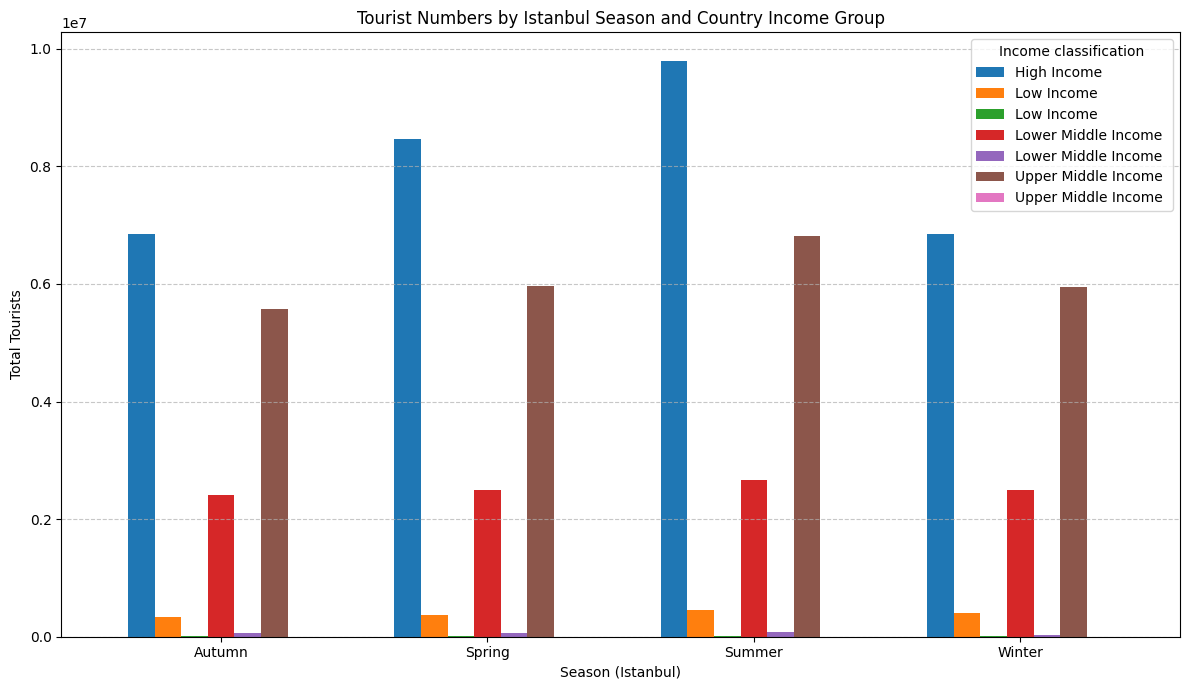

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

#Load data
df = pd.read_csv("/Users/boracomert/Desktop/Bora-DSA210-Project-1/merged_output.csv")

# Prepare Season Jnauary,February,March = winter ; April , May, June = spring ; July, August, Septembre = Summer; October, November ,december = winter 
df['Date'] = pd.to_datetime(df['Date'])
month_to_season = {1: 'Winter', 4: 'Spring', 7: 'Summer', 10: 'Autumn'}
df['Season'] = df['Date'].dt.month.map(month_to_season)

# 3. Group by Season and Income Classification
income_group = df.groupby(['Season', 'Income classification'])['ziyaretci_sayisi'].sum().reset_index()
income_pivot = income_group.pivot(index='Season', columns='Income classification', values='ziyaretci_sayisi').fillna(0)

# Drop columns income groups with missing data
income_pivot = income_pivot.loc[:, (income_pivot != 0).any(axis=0)]

# Drop rows with missing data
income_pivot = income_pivot[(income_pivot.T != 0).any()]

# Chi-Square Test of independence
chi2_income, p_income, dof_income, _ = chi2_contingency(income_pivot)

print("Chi-Square Test: Istanbul Season vs. Country Income Classification")
print(f"Chi2 statistic: {chi2_income:.3f}")
print(f"P-value: {p_income:.5f}")
print(f"Degrees of freedom: {dof_income}")

# Plot the pivot table
income_pivot.plot(kind='bar', figsize=(12, 7), width=0.7)
plt.title('Tourist Numbers by Istanbul Season and Country Income Group')
plt.ylabel('Total Tourists')
plt.xlabel('Season (Istanbul)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


  year_month  ziyaretci_sayisi  YoY_Inflation (%)  tr/usd_exchange_rate
0    2019-01            918949          17.591869                5.2873
1    2019-02            984689          16.653696                5.1803
2    2019-03           1165591          16.228748                5.3048
3    2019-04           1329868          15.610860                5.5889
4    2019-05           1016809          15.887157                5.9650


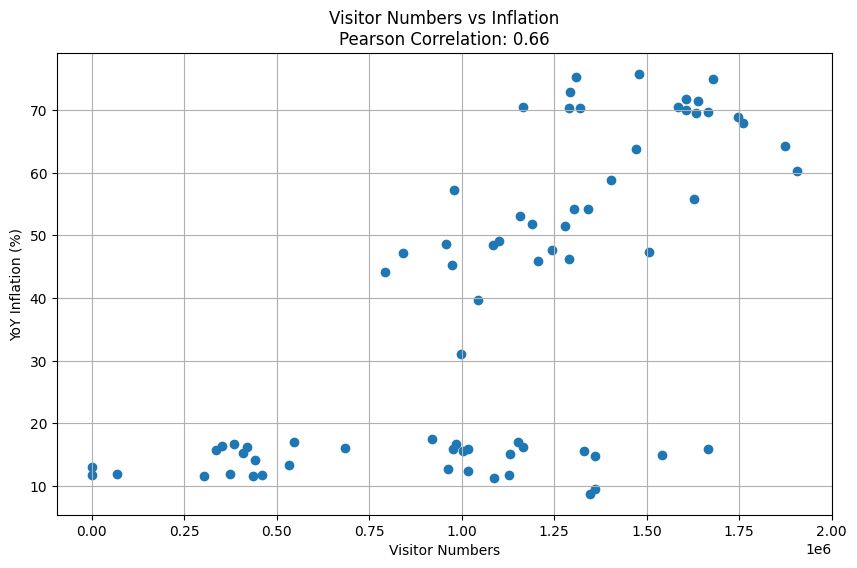

Visitor vs Inflation Pearson Correlation: 0.66


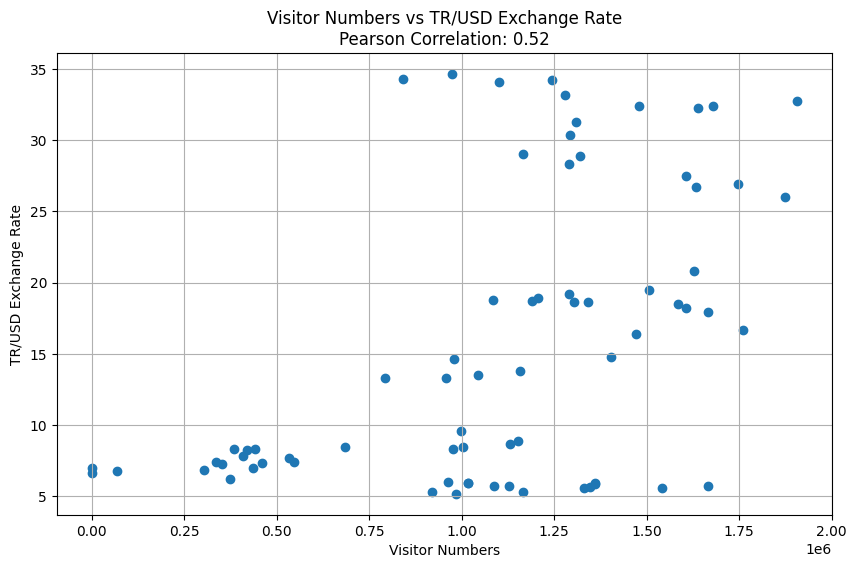

Visitor vs Exchange Rate Pearson Correlation: 0.52


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the data
file_path = 'merged_visitors_inflation.csv'  
df = pd.read_csv(file_path)


print(df.head())

# Visitor Numbers vs Inflation 

# Calculate Pearson correlation
visitor_inflation_corr, _ = pearsonr(df['ziyaretci_sayisi'], df['YoY_Inflation (%)'])

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['ziyaretci_sayisi'], df['YoY_Inflation (%)'])
plt.title(f'Visitor Numbers vs Inflation\nPearson Correlation: {visitor_inflation_corr:.2f}')
plt.xlabel('Visitor Numbers')
plt.ylabel('YoY Inflation (%)')
plt.grid(True)
plt.show()

print(f"Visitor vs Inflation Pearson Correlation: {visitor_inflation_corr:.2f}")

# Visitor Numbers vs Exchange Rate 

# Calculate Pearson correlation
visitor_exchange_corr, _ = pearsonr(df['ziyaretci_sayisi'], df['tr/usd_exchange_rate'])

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['ziyaretci_sayisi'], df['tr/usd_exchange_rate'])
plt.title(f'Visitor Numbers vs TR/USD Exchange Rate\nPearson Correlation: {visitor_exchange_corr:.2f}')
plt.xlabel('Visitor Numbers')
plt.ylabel('TR/USD Exchange Rate')
plt.grid(True)
plt.show()

print(f"Visitor vs Exchange Rate Pearson Correlation: {visitor_exchange_corr:.2f}")


Hypothesis Testing

Chi Square Test between Humidity of Istanbul and Humidity of Countries :
Chi^2: 2240070.010 
p-value: 0.00000 
dof: 2
Critical Chi^2 Value: 5.991464547107979


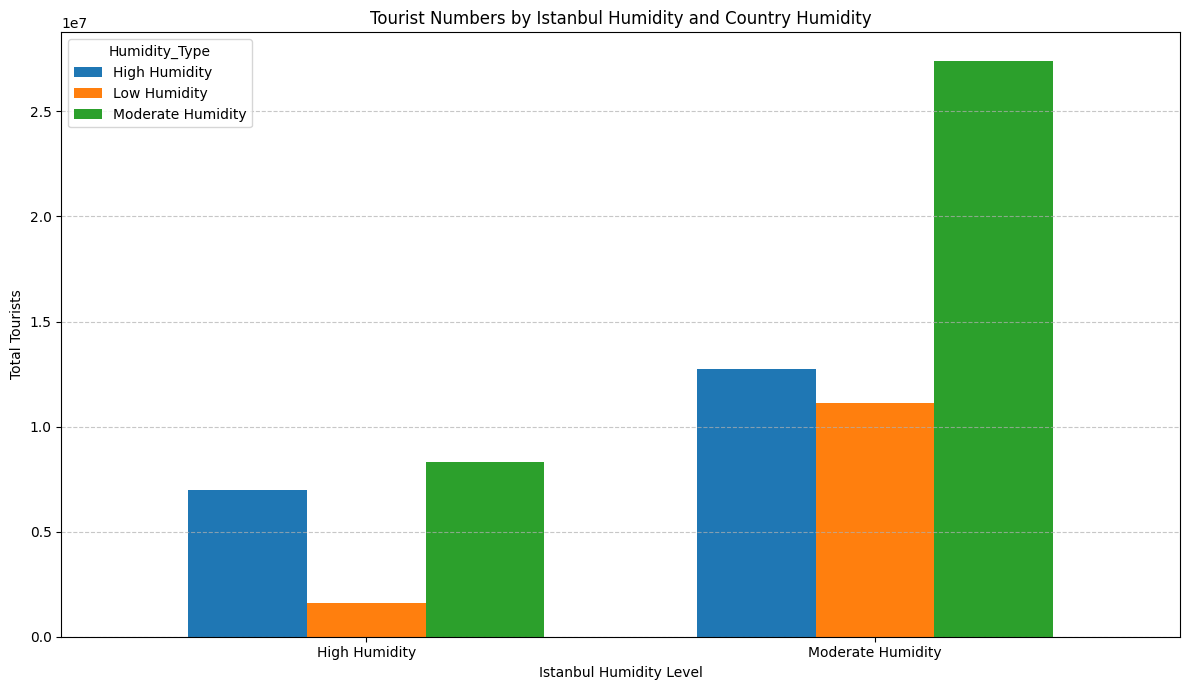

In [63]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Read your data
df = pd.read_csv("/Users/boracomert/Desktop/Bora-DSA210-Project-1/filtered_merged_output.csv")

# Group function
def group_by_weather(df):
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Classify country temperature
    def classify_country(temp):
        if temp > 20:
            return 'Warm'
        elif temp > 10:
            return 'Moderate'
        else:
            return 'Cold'
    df['Country_Type'] = df['Country_Temp'].apply(classify_country)
    
    # Classify country humidity
    def classify_country_humidity(humidity):
        if humidity < 40:
            return 'Low Humidity'
        elif humidity <= 70:
            return 'Moderate Humidity'
        else:
            return 'High Humidity'
    df['Humidity_Type'] = df['Country_Humidity'].apply(classify_country_humidity)
    
    # Classify country precipitation
    def classify_country_precip(precip):
        if precip < 500:
            return 'Low Precipitation'
        elif precip <= 1000:
            return 'Moderate Precipitation'
        else:
            return 'High Precipitation'
    df['Precipitation_Type'] = df['Country_Precipitation'].apply(classify_country_precip)
    
    # Classify Istanbul humidity
    def classify_istanbul_humidity(humidity):
        if humidity < 40:
            return 'Low Humidity'
        elif humidity <= 70:
            return 'Moderate Humidity'
        else:
            return 'High Humidity'
    df['Istanbul_Humidity_Type'] = df['Avg Humidity (%)'].apply(classify_istanbul_humidity)
    
    return df

df = group_by_weather(df)

# Group by Istanbul  and Country Humidity
humidity_group = df.groupby(['Istanbul_Humidity_Type', 'Humidity_Type'])['Visitors'].sum().reset_index()
humidity_pivot = humidity_group.pivot(index='Istanbul_Humidity_Type', columns='Humidity_Type', values='Visitors').fillna(0)

# Run Chi Square tests
alpha = 0.05
chi2_critical = chi2.ppf(1 - alpha, dof_hum)
chi2_hum, p_hum, dof_hum, _ = chi2_contingency(humidity_pivot)
print("Chi Square Test between Humidity of Istanbul and Humidity of Countries :")
print(f"Chi^2: {chi2_hum:.3f} ")
print(f"p-value: {p_hum:.5f} ")
print(f"dof: {dof_hum}")
print("Critical Chi^2 Value:", chi2_critical)

#Plot humidity / Tourist Number
humidity_pivot.plot(kind='bar', figsize=(12,7), width=0.7)
plt.title('Tourist Numbers by Istanbul Humidity and Country Humidity')
plt.ylabel('Total Tourists')
plt.xlabel('Istanbul Humidity Level')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()





Chi^square Statistic: 26093420.68
Degrees of Freedom : 6
Critical Value (for alpha == 0.05): 12.59
P-Value : 0.00


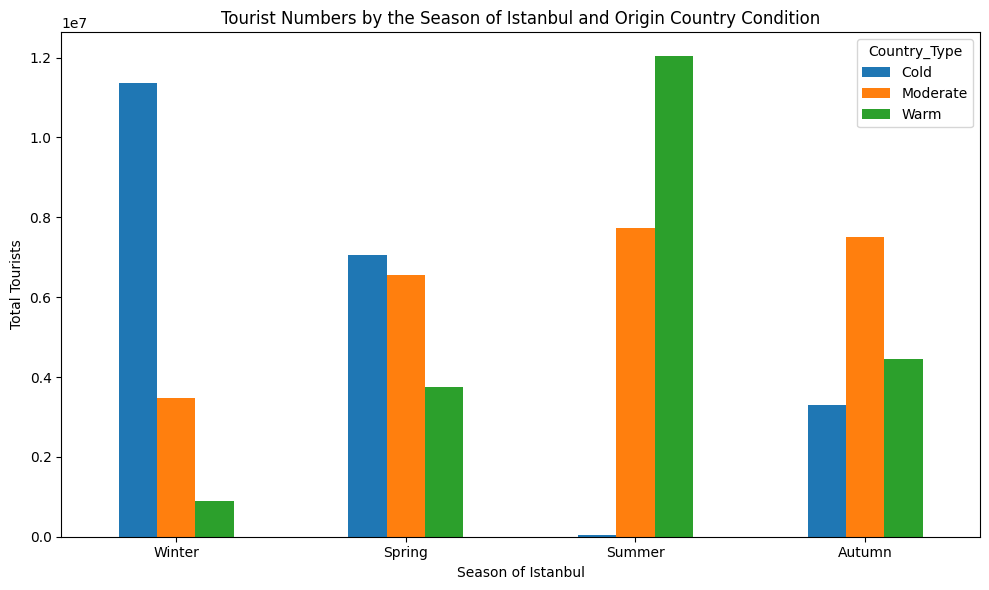

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2

# Grouping function to group total number of tourist based on country weather type and Istanbul Temperature 
def group_by_season(df):
    df['Date'] = pd.to_datetime(df['Date'])
    
    #Classify seasons according to first month 
    month_to_season = {
        1: 'Winter',
        4: 'Spring',
        7: 'Summer',
        10: 'Autumn'
    }
    df['Season'] = df['Date'].dt.month.map(month_to_season)
    #Classify country based on average temperature at that season
    def classify_country(temp):
        if temp > 20:
            return 'Warm'
        elif temp > 10:
            return 'Moderate'
        else:
            return 'Cold'
        
   
    df['Country_Type'] = df['Country_Temp'].apply(classify_country)
    return df


seasons_df = pd.read_csv("/Users/boracomert/Desktop/Bora-DSA210-Project-1/merged_output.csv")

# Create a table using our new function 
df = group_by_season(seasons_df)

season_country_group = df.groupby(['Season', 'Country_Type'])['ziyaretci_sayisi'].sum().reset_index()
#Fill empty rows (if any exists) 0 
pivot_table = season_country_group.pivot(index='Season', columns='Country_Type', values='ziyaretci_sayisi').fillna(0)

# Seasons are ordered based on time
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
pivot_table = pivot_table.reindex(season_order)

# Apply Chi Square Test
chi2_stat, p_val, dof, expected = chi2_contingency(pivot_table)
alpha = 0.05
critical_val = chi2.ppf(1 - alpha, dof)

# Chi Square Statistics
print(f"Chi^square Statistic: {chi2_stat:.2f}")
print(f"Degrees of Freedom : {dof}")
print(f"Critical Value (for alpha == 0.05): {critical_val:.2f}")
print(f"P-Value : {p_val:.2f}")

# Visulize Plot
pivot_table.plot(kind='bar', figsize=(10, 6))
plt.title('Tourist Numbers by the Season of Istanbul and Origin Country Condition')
plt.ylabel('Total Tourists')
plt.xlabel('Season of Istanbul')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


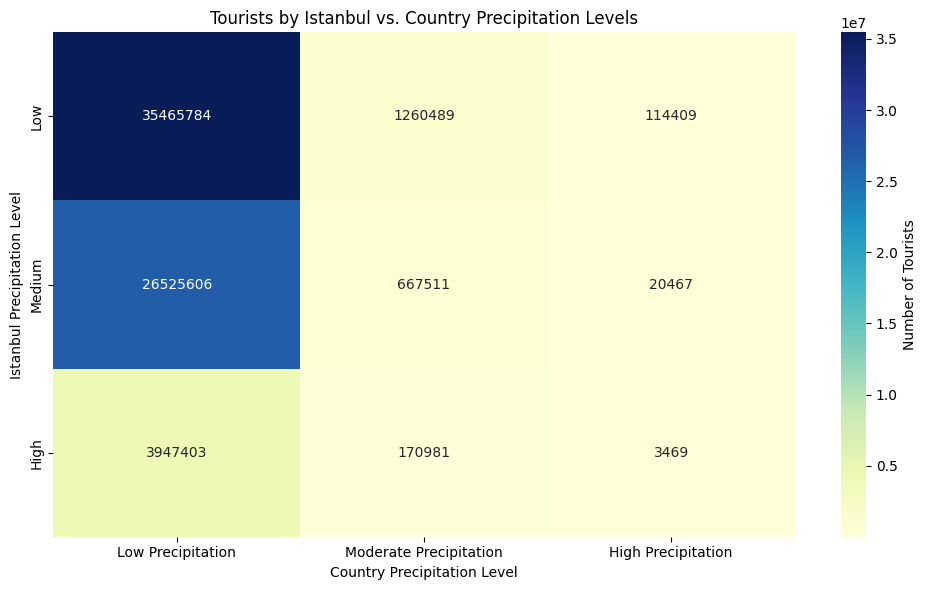

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("/Users/boracomert/Desktop/Bora-DSA210-Project-1/merged_output.csv")

# Classify Istanbul Precipitation
def classify_istanbul_precip(precip):
    if precip < 50:
        return 'Low'
    elif precip <= 100:
        return 'Medium'
    else:
        return 'High'

# Classify Country Precipitation
def classify_country_precip(precip):
    if precip < 500:
        return 'Low Precipitation'
    elif precip <= 1000:
        return 'Moderate Precipitation'
    else:
        return 'High Precipitation'

# Apply the classifications
df['Istanbul_Precip_Type'] = df['Total Precipitation (mm)'].apply(classify_istanbul_precip)
df['Precipitation_Type'] = df['Country_Precipitation'].apply(classify_country_precip)

# Create pivot table: Istanbul Precip Type (rows) vs Country Precip Type (columns)
pivot_precip = df.groupby(['Istanbul_Precip_Type', 'Precipitation_Type'])['ziyaretci_sayisi'].sum().unstack().fillna(0)

# Reorder for cleaner visuals
pivot_precip = pivot_precip.reindex(index=['Low', 'Medium', 'High'],
                                     columns=['Low Precipitation', 'Moderate Precipitation', 'High Precipitation'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_precip, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Number of Tourists'})
plt.title("Tourists by Istanbul vs. Country Precipitation Levels")
plt.xlabel("Country Precipitation Level")
plt.ylabel("Istanbul Precipitation Level")
plt.tight_layout()
plt.show()


Machine Learning

Before developing a machine learning model, we need to add the yoy_inflation.csv to our data. But first we need to convert it from monthly yoy inflation to seasonal. We will use the mean of the data.

In [ ]:
import pandas as pd

# Load your data
df = pd.read_csv("yoy_inflation.csv", parse_dates=["Month"])
df = df.sort_values("Month").reset_index(drop=True)

# Divide the time into quarters
df["Quarter"] = df.index //3

# Group dates so the first month will be the season indicator , so it will be the same format as our data.
group_starts = df.groupby("Quarter")["Month"].first()
df["Date"] = df["Quarter"].map(group_starts)

#Take the mean value of the season and group them to the first month
Seasonal_yoy_inflation = df.groupby("Date")["YoY_Inflation (%)"].mean().reset_index()

# format the - so the it will be the same format as our filtered_merged_output
Seasonal_yoy_inflation["Date"] = Seasonal_yoy_inflation["Date"].dt.strftime("%Y-%m-%d")

#save as a seperate csv file
Seasonal_yoy_inflation.to_csv("Seasonal_yoy_inflation.csv",index=False)

#Load our main dataset and the dataset we saved
inflation_df = pd.read_csv("Seasonal_yoy_inflation.csv", parse_dates=["Date"])
main_df = pd.read_csv("filtered_merged_output.csv", parse_dates=["Date"])
merged = pd.merge(main_df, inflation_df, on="Date", how="left")
merged.to_csv("filtered_merged_with_inflation.csv", index=False)

merged.head()



,Date,Country,Country_Temp,Country_Humidity,Country_Precipitation,Avg Temperature (C),Avg Humidity (%),Total Precipitation (mm),Visitors,Income classification,YoY_Inflation (%)
0,2019-01-01,AUS,28.13,43.30,205.00,8.475422,70.202765,77.666667,4087.0,High Income,16.824771
1,2019-04-01,AUS,23.09,46.53,92.80,18.119355,66.005735,28.066667,17511.0,High Income,15.438512
2,2020-01-01,AUS,28.43,43.21,211.97,8.450130,69.750463,85.466667,1746.0,High Income,12.348299
3,2020-04-01,AUS,23.15,47.01,98.12,16.768459,62.811470,64.100000,221.0,High Income,12.223215
4,2022-01-01,AUS,28.25,43.20,211.61,6.649386,69.688172,73.133333,8848.0,High Income,48.615445


Now that we have everything ready. We need to decide what are predicators and estimators. Our model is going to to give us the number of tourists coming to istanbul from a country. So our predictors should be remaining columns. But first let check multicolinerity.

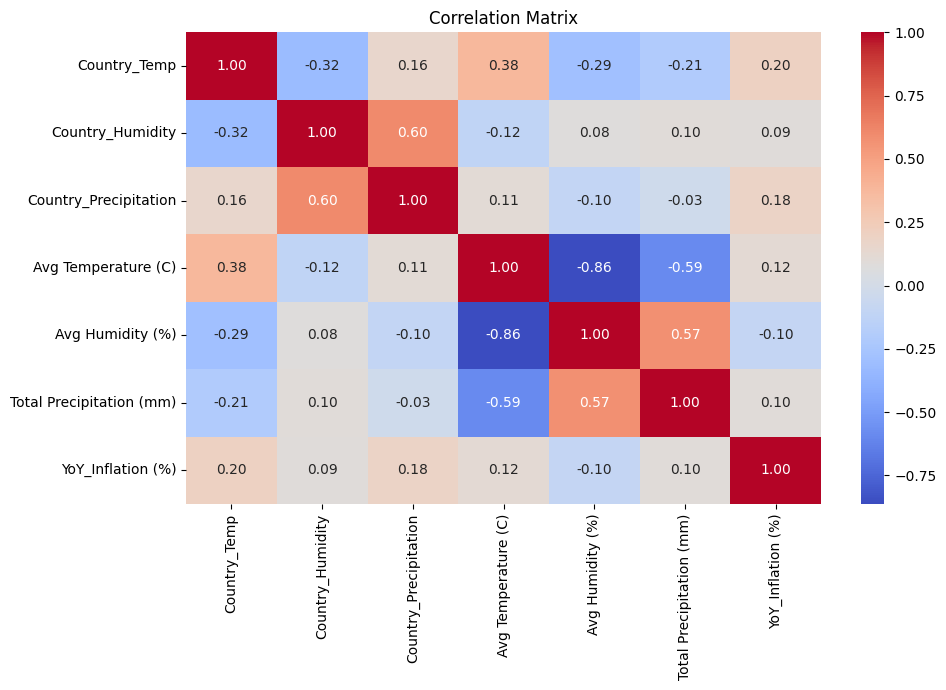

Variance Inflation Factor (VIF) Scores:

                    Feature          VIF
0                     const  1282.178385
4       Avg Temperature (C)     4.411763
5          Avg Humidity (%)     4.024948
2          Country_Humidity     2.186522
3     Country_Precipitation     2.005954
6  Total Precipitation (mm)     1.638862
1              Country_Temp     1.607103
7         YoY_Inflation (%)     1.123432


In [31]:

import matplotlib.pyplot as plt
import statsmodels.api as statsmodel
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import seaborn as sns
from statsmodels.tools.tools import add_constant


df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

predictors = [
    "Country_Temp",
    "Country_Humidity",
    "Country_Precipitation",
    "Avg Temperature (C)",
    "Avg Humidity (%)",
    "Total Precipitation (mm)",
    "YoY_Inflation (%)"
]

X = df[predictors]

plt.figure(figsize=(10, 7))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

X_const = add_constant(X) 

vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print("Variance Inflation Factor (VIF) Scores:\n")
print(vif_data.sort_values(by="VIF", ascending=False))


There is a slight correlation between Istanbul's Average Humidity and Average Temperature but it is expected since Temperature affect humidity.
Since VIF score < 5 we don't have to drop it.

Training And Testing Machine Learning Models

K Nearest Neigbours Model

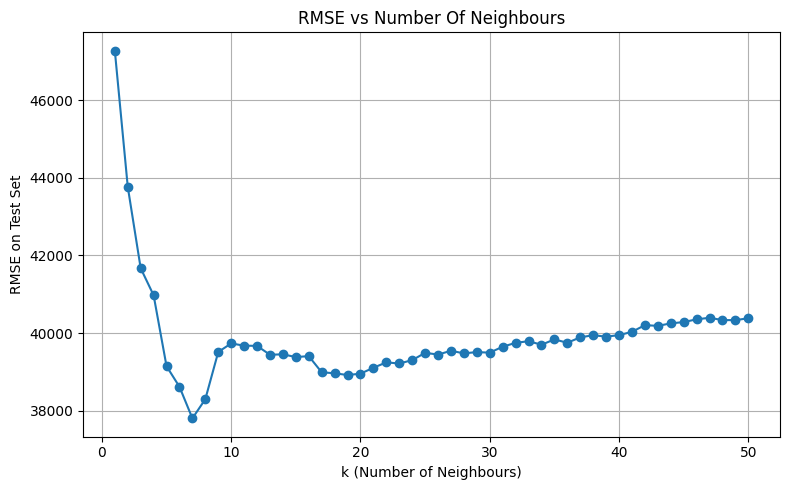

Best k: 7 with RMSE: 37808.49


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Label encode categorical features
le_income = LabelEncoder()
df["Income_encoded"] = le_income.fit_transform(df["Income classification"])
le_country = LabelEncoder()
df["Country_encoded"] = le_country.fit_transform(df["Country"])

# Define features
predictors = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded", "Country_encoded"
]
X = df[predictors]
y = df["Visitors"]

# Train test split and z score scaling for KNN 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different values of k
k_values = range(1, 51)
rmse_list = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

# Plot RMSE vs Number of Neigbours
plt.figure(figsize=(8, 5))
plt.plot(k_values, rmse_list, marker='o')
plt.xlabel("k (Number of Neighbours)")
plt.ylabel("RMSE on Test Set")
plt.title("RMSE vs Number Of Neighbours")
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = k_values[np.argmin(rmse_list)]
print(f"Best k: {best_k} with RMSE: {min(rmse_list):.2f}")


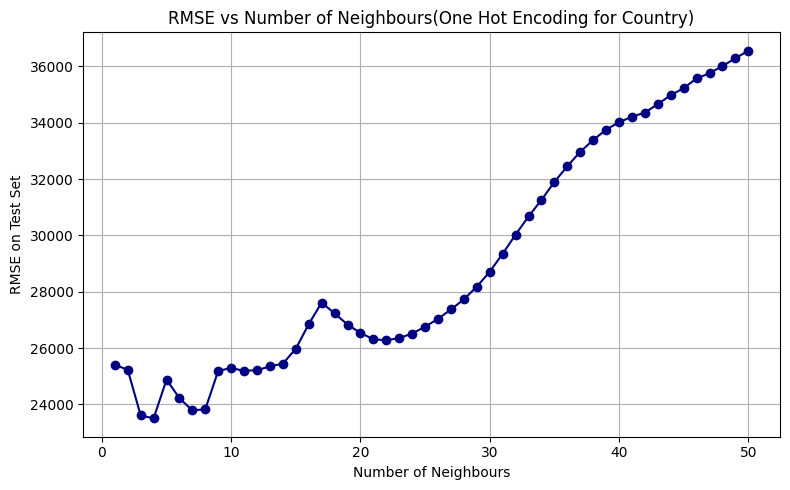

Best k: 4 with RMSE: 23505.06


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Label encode 'Income classification' (ordinal)
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])

# One-hot encode 'Country'
country_dummies = pd.get_dummies(df["Country"], prefix="Country", drop_first=True)
df_encoded = pd.concat([df, country_dummies], axis=1)

# Define feature columns (replace Country_encoded with one-hot columns)
predictors = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded"
] + list(country_dummies.columns)

# Features and target
X = df_encoded[predictors]
y = df_encoded["Visitors"]

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaling is neccessary for KNN to work 
#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different values of k
k_values = range(1, 51)
rmse_list = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

# Plot RMSE vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, rmse_list, marker='o', color='navy')
plt.xlabel("Number of Neighbours")
plt.ylabel("RMSE on Test Set")
plt.title("RMSE vs Number of Neighbours(One Hot Encoding for Country)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best k
best_k = k_values[np.argmin(rmse_list)]
print(f"Best k:{best_k} with RMSE: {min(rmse_list):.2f}")


Encoding Country column with one hot encoding proves more effective at predicting visitor numbers 

RMSE: 23505.06
R^2 Score: 0.7296


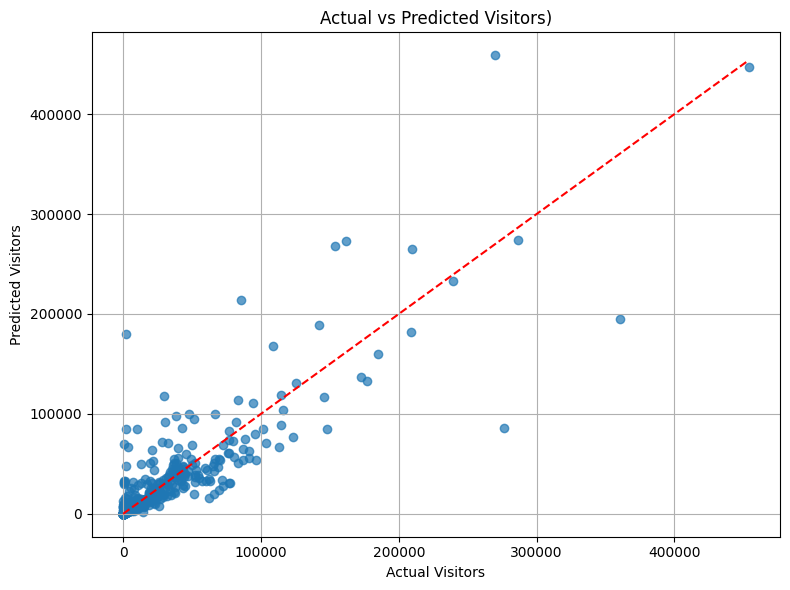

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Label Encoding for Income Classification because more high income countries come more and one Hot Encoding for country column
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])
country_dummies = pd.get_dummies(df["Country"], prefix="Country", drop_first=True)
df_encoded = pd.concat([df, country_dummies], axis=1)

# Define predictors (replace Country_encoded with actual one-hot columns)
predictors = [
    "Country_Temp",
    "Country_Humidity",
    "Country_Precipitation",
    "Avg Temperature (C)",
    "Avg Humidity (%)",
    "Total Precipitation (mm)",
    "YoY_Inflation (%)",
    "Income_encoded"
] + list(country_dummies.columns)  # add all one-hot columns

# Features and target
X = df_encoded[predictors]
y = df_encoded["Visitors"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN model
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train_scaled, y_train)

# Predict
y_pred = knn.predict(X_test_scaled)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Visitors")
plt.ylabel("Predicted Visitors")
plt.title("Actual vs Predicted Visitors)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Label Encoding for Income Classification because more high income countries come more
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])

# One-hot encode 'Country'
country_dummies = pd.get_dummies(df["Country"], prefix="Country", drop_first=True)
df_encoded = pd.concat([df, country_dummies], axis=1)

# Define predictors
predictors = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded"
] + list(country_dummies.columns)

# Features and target
X = df_encoded[predictors]
y = df_encoded["Visitors"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize KNN
k = 5
knn = KNeighborsRegressor(n_neighbors=k)

#5 Fold Cross-Validation (scoring uses negative MSE, so take sqrt of -score)
cv_scores = cross_val_score(knn, X_scaled, y, cv=5, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-cv_scores)

# Print results
print(f"Cross-Validation RMSE Scores for k = 5): {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.2f}")
print(f"Std Deviation: {rmse_scores.std():.2f}")


Cross-Validation RMSE Scores (k=5): [14740.78469004 55886.44534054 62113.35298067 93965.76169791
 20713.97639702]
Mean RMSE: 49484.06
Std Deviation: 29030.76


Train Test split RMSE = 23505.06 while Mean RMSE: 49484.06 from 5 fold cross validation indicates that model's performance is inconsistent.


Random Forest Model

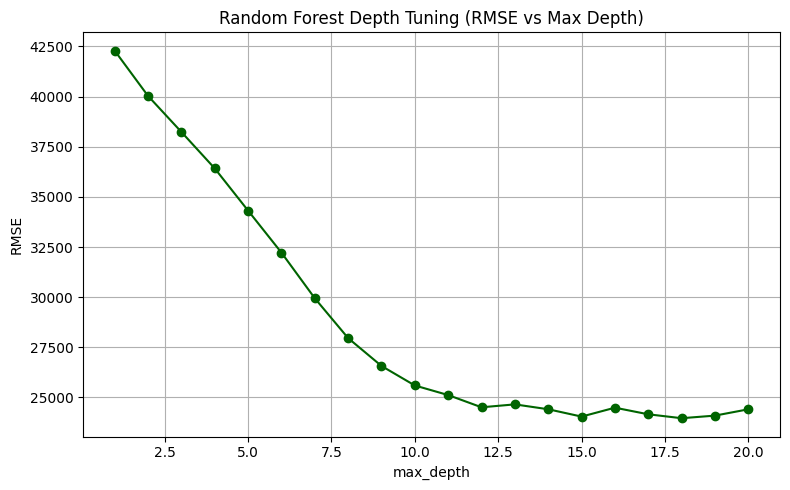

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Encode categorical features
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])
df["Country_encoded"] = LabelEncoder().fit_transform(df["Country"])

# Define features and target
predictors = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded", "Country_encoded"
]
X = df[predictors]
y = df["Visitors"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Try different max_depth values
depths = list(range(1, 21))
rmse_scores = []

for depth in depths:
    rf = RandomForestRegressor(max_depth=depth, n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(depths, rmse_scores, marker='o', color='darkgreen')
plt.title("Random Forest Depth Tuning (RMSE vs Max Depth)")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()


n_estimators=10 → RMSE=24234.96
n_estimators=50 → RMSE=23816.80
n_estimators=100 → RMSE=24047.03
n_estimators=150 → RMSE=24125.11
n_estimators=200 → RMSE=24331.84
n_estimators=250 → RMSE=24455.09
n_estimators=300 → RMSE=24355.54
n_estimators=400 → RMSE=24440.57
n_estimators=500 → RMSE=24517.82


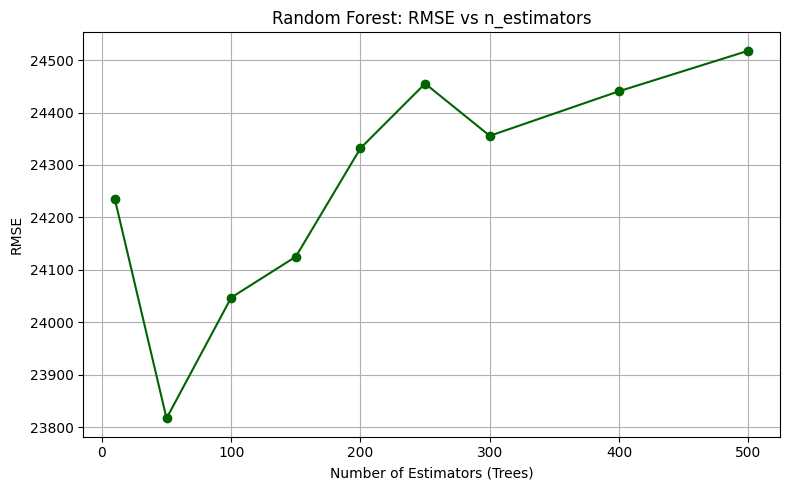

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Encode categorical features
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])
df["Country_encoded"] = LabelEncoder().fit_transform(df["Country"])

# Features and target
predictors = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded", "Country_encoded"
]
X = df[predictors]
y = df["Visitors"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Range of n_estimators to test
n_list = [10, 50, 100, 150, 200, 250, 300, 400, 500]
rmse_scores = []

for n in n_list:
    rf = RandomForestRegressor(n_estimators=n, max_depth=15, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print(f"n_estimators={n} → RMSE={rmse:.2f}")

# Plot RMSE vs n_estimators
plt.figure(figsize=(8, 5))
plt.plot(n_list, rmse_scores, marker='o', color='darkgreen')
plt.xlabel("Number of Estimators (Trees)")
plt.ylabel("RMSE")
plt.title("Random Forest: RMSE vs n_estimators")
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest RMSE: 23816.80
R² Score: 0.7224


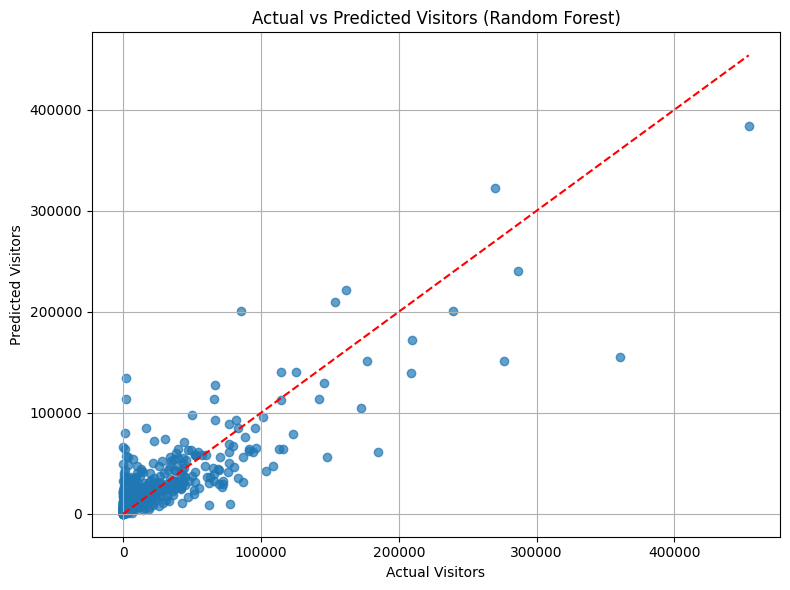

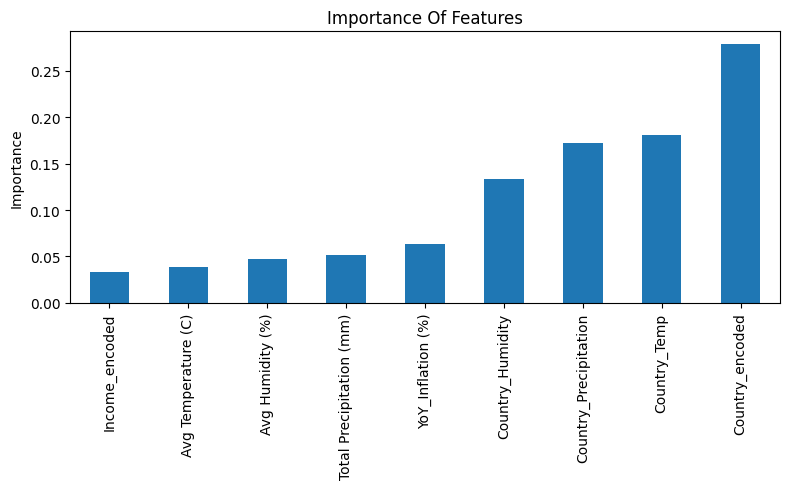

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Label encode categorical features
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])
df["Country_encoded"] = LabelEncoder().fit_transform(df["Country"])

# Define features and target
predictors = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded", "Country_encoded"
]
X = df[predictors]
y = df["Visitors"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7,)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Visitors")
plt.ylabel("Predicted Visitors")
plt.title("Actual vs Predicted Visitors (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance
importances = rf.feature_importances_
features = pd.Series(importances, index=predictors).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
features.plot(kind="bar")
plt.title("Importance Of Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [55]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Label encode categorical columns
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])
df["Country_encoded"] = LabelEncoder().fit_transform(df["Country"])

# Define features and target
predictors = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded", "Country_encoded"
]
X = df[predictors].values
y = df["Visitors"].values

# Initialize model and CV
model = RandomForestRegressor(n_estimators=100, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store RMSEs
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

# Convert to array for stats
rmse_scores = np.array(rmse_scores)

# Output
print(f"Cross Validation RMSE Scores (k=5): {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.2f}")
print(f"Standard Deviation: {rmse_scores.std():.2f}")


Cross Validation RMSE Scores (k=5): [24773.61223564 28022.95107626 30912.70925616 30524.94428591
 27966.29144994]
Mean RMSE: 28440.10
Standard Deviation: 2204.63


Absence of big outliers and RMSE value being closer to the best output (23816.80) indicates that the model is not prone to overfitting

Multilinear Regression

Multilinear Regression RMSE: 25949.98
Multilinear Regression R^2 Score: 0.6704


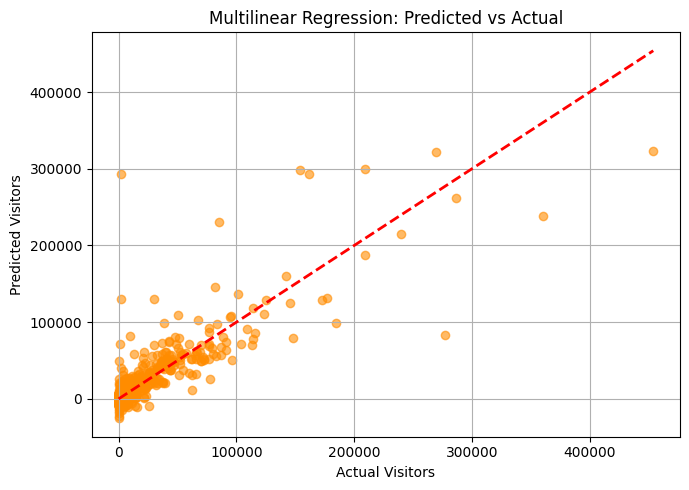

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Label encode Income classification (ordinal-ish)
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])

# One-hot encode Country using pandas
df = pd.get_dummies(df, columns=["Country"], drop_first=True)

# Define features and target
features = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded"
]

# Add one-hot encoded country columns
country_columns = [col for col in df.columns if col.startswith("Country_")]
X = df[features + country_columns]
y = df["Visitors"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

# Create a plot of Predicted vs Actual
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Visitors")
plt.ylabel("Predicted Visitors")
plt.title("Multilinear Regression: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


Number of tourist per countries are not uniform some countries have 20 tourists while some have over 100000 this is a issue where multilinear models struggle with so adding a log transform to the Y might improve our result

RMSE: 0.97
R^2 Score: 0.8654


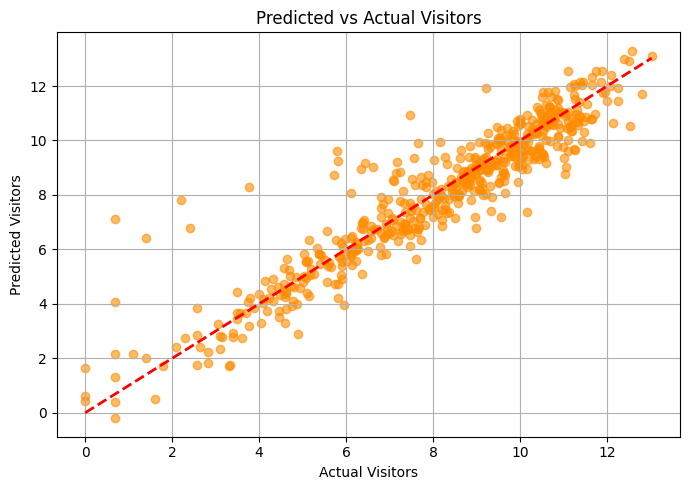

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Label encode Income classification (if needed)
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])

# One-hot encode 'Country' using pandas
df_country_dummies = pd.get_dummies(df["Country"], prefix="Country", drop_first=True)
df_encoded = pd.concat([df, df_country_dummies], axis=1)

# Define features manually (excluding original 'Country')
features = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded"
] + list(df_country_dummies.columns)

X = df_encoded[features]
y = np.log(df_encoded["Visitors"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model with 20/80 test train split
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Visitors")
plt.ylabel("Predicted Visitors")
plt.title("Predicted vs Actual Visitors")
plt.grid(True)
plt.tight_layout()
plt.show()


Yes log transform improved the accuracy of our model. But this could also result in Overfitting of our model. Lets do a cross validation test to see if our model is prone to overfitting 

In [61]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer

# Load dataset
df = pd.read_csv("filtered_merged_with_inflation.csv", parse_dates=["Date"])

# Encode Income classification
df["Income_encoded"] = LabelEncoder().fit_transform(df["Income classification"])

# One-hot encode 'Country'
df_country_dummies = pd.get_dummies(df["Country"], prefix="Country", drop_first=True)
df_encoded = pd.concat([df, df_country_dummies], axis=1)

# Define features
features = [
    "Country_Temp", "Country_Humidity", "Country_Precipitation",
    "Avg Temperature (C)", "Avg Humidity (%)", "Total Precipitation (mm)",
    "YoY_Inflation (%)", "Income_encoded"
] + list(df_country_dummies.columns)

X = df_encoded[features]
y = np.log(df_encoded["Visitors"])

# #Define Model 
model = LinearRegression()
#Define cross validation and set fold number 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Apply the Cross validation
cv_rmse = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
cv_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')

# Print results
print("5 Fold Cross Validation:")
print(f"Average RMSE: {cv_rmse.mean():.2f}")
print(f"Average R^2 Score : {cv_r2.mean():.4f}")


5 Fold Cross Validation:
Average RMSE: 0.93
Average R^2 Score : 0.8806


The result indicate that the model does not overfit. 